# 프로젝트: 한국어 데이터로 챗봇 만들기
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

- songys/Chatbot_data

In [2]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf

In [3]:
chatbot = pd.read_csv('./data/ChatbotData .csv')

In [4]:
chatbot

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# Step 2. 데이터 전처리하기
- 공백, 특수문자 처리

In [82]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^가-힣0-9a-zA-Z.?!,]', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [6]:
sentence = '3박4일 놀러가고 싶다'

In [7]:
preprocess_sentence(sentence)

'3박4일 놀러가고 싶다'

# Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [8]:
questions = chatbot.Q.tolist()
answers = chatbot.A.tolist()

In [9]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [13]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


### 적절한 패딩 길이 구하기

In [14]:
import matplotlib.pyplot as plt

In [15]:
num_questions = [len(tokens) for tokens in questions]
num_questions = np.array(num_questions)


# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_questions)}")
print(f"토큰 길이 최대: {np.max(num_questions)}")
print(f"토큰 길이 표준편차: {np.std(num_questions)}")

토큰 길이 평균: 12.879049310665652
토큰 길이 최대: 56
토큰 길이 표준편차: 6.167205838440642


In [16]:
num_answers = [len(tokens) for tokens in answers]
num_answers = np.array(num_answers)


# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_answers)}")
print(f"토큰 길이 최대: {np.max(num_answers)}")
print(f"토큰 길이 표준편차: {np.std(num_answers)}")

토큰 길이 평균: 15.0151399813922
토큰 길이 최대: 76
토큰 길이 표준편차: 6.70155143772292


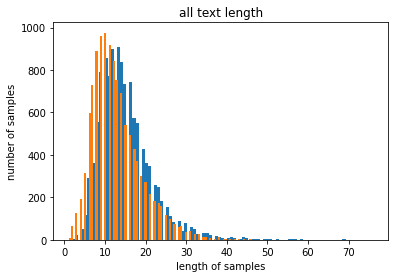

In [17]:
plt.title('all text length')
plt.hist(num_answers, bins=100)
plt.hist(num_questions, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(select_length, answers)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9924722997547154


In [20]:
below_threshold_len(select_length, questions)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9984775437706166


In [21]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


### 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩

In [22]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [23]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [24]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

추가적으로 모델 저장을 위해 `get_config()`와 `__init__`부분을 수정하였다

- 모델 선정 이유
    >- transformer는 자연어 처리 작업에서 좋은 성능을 발휘하는 것으로 알려져 있다.
    >- 특히 문장의 길이에 관계없이 문맥을 잘 이해하고 다룰 수 있는 능력이 강점이다. 

- Metrics 선정 이유
    >- 모델이 생성한 문장이 정확하게 의미를 전달하는지를 중요하게 여기기 때문에 accuracy 메트릭을 사용했다.
    >- 이 메트릭은 모델이 단어 수준에서 얼마나 정확하게 예측하는지를 측정한다. 
    >- 이 외에도 BLEU나 ROUGE 등의 자동 평가 지표를 사용하여 모델의 출력을 사람이 직접 평가하는 경우와 비교할 수도 있다.

- Loss 선정 이유
    >- 우리가 다루는 과제는 문장 생성 문제이며, 희소한 출력 공간에서 정확한 단어를 예측하는 것이 중요하다. 
    >- 이를 위해 sparse categorical crossentropy 손실 함수를 선택했다. 
    >- 이 함수는 다중 클래스 분류 문제에서 주로 사용되며, 우리의 출력이 정수 형태의 토큰 ID로 표현되기 때문에 적합하다. 
    >- 또한, 패딩된 부분을 무시하기 위한 mask를 적용하여 모델이 패딩 토큰을 무시하도록 했다.


In [25]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [26]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
    
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

In [28]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [29]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    #################################################
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션) #
    ################################################
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    ##############################################################
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션) #
    ##############################################################
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    ##################################
    # 세 번째 서브 레이어 : 2개의 완전연결층 #
    #################################
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3146240     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [34]:
# 손실 함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 커스텀 된 학습률(Learning rate)

$$ lrate = d^{-0.5}_{model} \cdot min(step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5}) $$

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            'd_model': int(self.d_model.numpy()),
            'warmup_steps': self.warmup_steps,
        }

In [36]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [56]:
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 10s 55ms/step - loss: 0.4242 - accuracy: 0.1039
Epoch 2/10
185/185 [==============================] - 10s 55ms/step - loss: 0.3437 - accuracy: 0.1149
Epoch 3/10
185/185 [==============================] - 10s 54ms/step - loss: 0.2684 - accuracy: 0.1265
Epoch 4/10
185/185 [==============================] - 10s 54ms/step - loss: 0.2050 - accuracy: 0.1363
Epoch 5/10
185/185 [==============================] - 10s 54ms/step - loss: 0.1507 - accuracy: 0.1455
Epoch 6/10
185/185 [==============================] - 10s 54ms/step - loss: 0.1078 - accuracy: 0.1537
Epoch 7/10
185/185 [==============================] - 10s 54ms/step - loss: 0.0786 - accuracy: 0.1590
Epoch 8/10
185/185 [==============================] - 10s 54ms/step - loss: 0.0616 - accuracy: 0.1618
Epoch 9/10
185/185 [==============================] - 10s 54ms/step - loss: 0.0506 - accuracy: 0.1636
Epoch 10/10
185/185 [==============================] - 10s 54ms/step - loss: 0.045

### Loss와 Accuracy 시각화

In [57]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


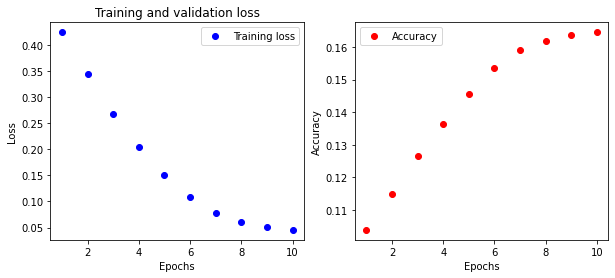

In [87]:
import matplotlib.pyplot as plt
 
acc = history.history['accuracy']
loss = history.history['loss']
 
epochs = range(1, len(acc) + 1)


fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, acc, 'ro', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 저장 및 로드

In [38]:
model.save('transformer_model.h5')

In [40]:
# 모델 로드
loaded_model = tf.keras.models.load_model('transformer_model.h5', 
                                          custom_objects={
    'CustomSchedule': CustomSchedule,
    'PositionalEncoding': PositionalEncoding,
    'MultiHeadAttention': MultiHeadAttention,
    'loss_function': loss_function
})

In [41]:
# 모델 로드 후 컴파일
loaded_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

## Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [42]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [43]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

## 테스트 및 평가
- 학습 데이터의 설명을 보면 다음과 같다

>
>인공데이터입니다. 일부 이별과 관련된 질문에서 다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작하였습니다. 가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 챗봇이 위로한다는 취지로 답변을 작성하였습니다.
>
    
    - 이에 따라서 이별이나 사랑 관련 키워드에 대한 답변을 잘하는 것으로 보인다.
    
- 토큰화를 좀 더 잘하면 성능이 올라갈 것으로 보인다 (띄어쓰기에 따라 인식되는 것이 달라지는 것으로 보임)
- 1박2일, 3박4일 등의 단어를 잘 이해하지 못한다

- 학습 데이터의 특성상 정보를 묻는 질문에 답을 잘 못한다

### 이별이나 사랑관련 키워드 질문 & 답변

In [80]:
sentence_generation('나 좋아하는 사람이 생겼어')

입력 : 나 좋아하는 사람이 생겼어
출력 : 축하해요.


'축하해요.'

In [67]:
sentence_generation('나 헤어졌어')

입력 : 나 헤어졌어
출력 : 헤어진 후에 자신을 더 돌봐주세요.


'헤어진 후에 자신을 더 돌봐주세요.'

### 띄어쓰기에 따른 성능차이 

In [69]:
sentence_generation('여행 가고 싶다')

입력 : 여행 가고 싶다
출력 : 같이 가자고 말해보세요


'같이 가자고 말해보세요'

In [79]:
sentence_generation('여행가고 싶다')

입력 : 여행가고 싶다
출력 : 계획을 세워보세요.


'계획을 세워보세요.'

In [75]:
sentence_generation('놀러가고 싶다')

입력 : 놀러가고 싶다
출력 : 저랑 놀아요.


'저랑 놀아요.'

In [48]:
sentence_generation('공부 싫어')

입력 : 공부 싫어
출력 : 지금도 늦지 않았어요.


'지금도 늦지 않았어요.'

In [51]:
sentence_generation('공부 하기 싫어')

입력 : 공부 하기 싫어
출력 : 저도 해보고 싶네요.


'저도 해보고 싶네요.'

### 숫자 이해
- 3박4일은 학습데이터에 있는 단어였다

In [77]:
sentence_generation('1박2일 놀러가고 싶다')

입력 : 1박2일 놀러가고 싶다
출력 : 가끔은 내로 자기한테 바보라고 하지 않아요.


'가끔은 내로 자기한테 바보라고 하지 않아요.'

In [78]:
sentence_generation('3박4일 놀러가고 싶다')

입력 : 3박4일 놀러가고 싶다
출력 : 여행은 언제나 좋죠.


'여행은 언제나 좋죠.'

### 학습이 부족한 내용들 

In [44]:
sentence_generation('저녁 뭐먹지?')

입력 : 저녁 뭐먹지?
출력 : 맛있는 거 드세요.


'맛있는 거 드세요.'

In [62]:
sentence_generation('오늘의 날씨는 어때?')

입력 : 오늘의 날씨는 어때?
출력 : 글을 쓰면 힘이 되지 않아요.


'글을 쓰면 힘이 되지 않아요.'

# 회고

- 배운 점 
    - transformer의 구조에 대해 좀 더 명확히 이해할 수 있었다
    - custom 모델 저장하는 방법을 배웠다 
- 아쉬운 점 
    - 프로젝트에서 한글 토큰을 잘 만들지 못해서 아쉬웠다
    - 토큰화를 잘 하지 못해서 띄어쓰기에 따라서 답변이 달라진다
- 느낀 점
    - transformer는 
- 어려웠던 점 
    - transformer의 구조를 이해하는데 어려웠다
    - custom 모델 저장하는 데 config 설정하는 것이 어려웠다